# Imports

In [1]:
import spotipy
import re

# math and dataframes
import pandas as pd
import numpy as np
from scipy.stats import zscore

# plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import seaborn as sns
sns.set_theme()

# jupyter notebook full-width display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# pandas formatting
pd.set_option('display.float_format', '{:.3f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

In [2]:
# all songs with audio features (combined from 3 sources)
df_10M = pd.read_pickle('df_10M.pickle')

# all Billboard 100 lists, audio features included where possible
df_B100 = pd.read_pickle('df_B100.pickle')

# all unique songs from the Billboard 100 lists, audio features included where possible
df_B100_songs = pd.read_pickle('df_B100_songs.pickle')

In [3]:
# confirm import worked (B100 songs are all in df_10M, no duplicates)
id_B100 = set(df_B100_songs[~df_B100_songs.id.isnull()].id)
len(id_B100), df_10M[df_10M.id.isin(id_B100)].shape[0]
# GOOD!

(21274, 21274)

# OUTLIERS

### Method 1:  IQR
(didn't work)

In [4]:
df_B100_range = df_B100_songs.describe().T[['min', 'max']]
df_outliers = df_10M.describe()['min':'max'].T

In [5]:
df_B100_range

,min,max
acousticness,0.000,0.996
danceability,0.000,0.988
duration_ms,12507.000,2902827.000
energy,0.000,0.999
instrumentalness,0.000,0.996
key,0.000,11.000
liveness,0.000,1.000
loudness,-60.000,2.291
mode,0.000,1.000
speechiness,0.000,0.949


In [6]:
df_outliers

,min,25%,50%,75%,max
acousticness,0.000,0.034,0.337,0.817,0.996
danceability,0.000,0.396,0.545,0.676,1.000
duration_ms,1000.000,169507.000,216851.000,275053.000,6072187.000
energy,0.000,0.311,0.567,0.789,1.000
instrumentalness,0.000,0.000,0.002,0.647,1.000
key,0.000,2.000,5.000,8.000,11.000
liveness,0.000,0.096,0.129,0.262,1.000
loudness,-60.000,-13.674,-9.195,-6.397,7.234
mode,0.000,0.000,1.000,1.000,1.000
speechiness,0.000,0.036,0.047,0.082,0.974


In [7]:
df_outliers['IQR'] = df_outliers['75%'] - df_outliers['25%']
df_outliers['out_low'] = df_outliers['25%'] - 1.5 * df_outliers['IQR']
df_outliers['out_high'] = df_outliers['75%'] + 1.5 * df_outliers['IQR']
df_outliers

,min,25%,50%,75%,max,IQR,out_low,out_high
acousticness,0.000,0.034,0.337,0.817,0.996,0.783,-1.142,1.992
danceability,0.000,0.396,0.545,0.676,1.000,0.280,-0.024,1.096
duration_ms,1000.000,169507.000,216851.000,275053.000,6072187.000,105546.000,11188.000,433372.000
energy,0.000,0.311,0.567,0.789,1.000,0.478,-0.406,1.506
instrumentalness,0.000,0.000,0.002,0.647,1.000,0.647,-0.970,1.617
key,0.000,2.000,5.000,8.000,11.000,6.000,-7.000,17.000
liveness,0.000,0.096,0.129,0.262,1.000,0.166,-0.152,0.510
loudness,-60.000,-13.674,-9.195,-6.397,7.234,7.277,-24.589,4.519
mode,0.000,0.000,1.000,1.000,1.000,1.000,-1.500,2.500
speechiness,0.000,0.036,0.047,0.082,0.974,0.047,-0.034,0.152


In [8]:
# this didn't exclude anything except liveliness > 0.51, speechiness > 0.152 and duration_ms
# let's check duration, to see if it's useful
df_outliers.loc['duration_ms', 'out_low'] / (60 * 1000), df_outliers.loc['duration_ms', 'out_high'] / (60 * 1000)

# 12 second songs, nope
# 7 minute songs, maybe

(0.18646666666666667, 7.2228666666666665)

### Method 2:  Z-scores
(didn't work)

#### ESTIMATE (not exactly correct unless Gaussian):
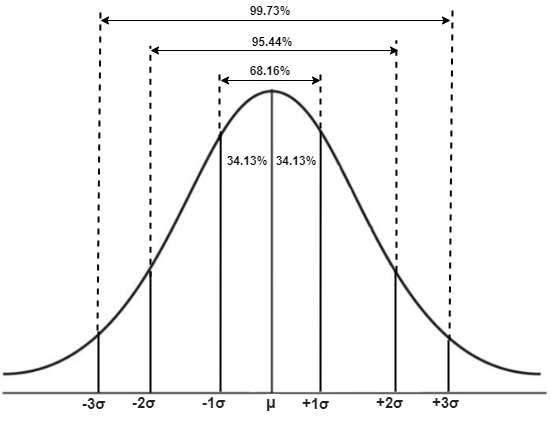

In [9]:
# helper function, check z scores
def check_z_score(z_exclude=3):
    z_scores = {1: 0.6816, 2: 0.9544, 3: 0.9973}
    z_exclude = z_exclude
    low_quartile = round((1 - z_scores[z_exclude]) / 2, 5)
    high_quartile = round(1 - (1 - z_scores[z_exclude]) / 2, 5)

    quartiles = [low_quartile, high_quartile]

    df_B100_range = df_B100_songs.describe().T
    df_10M_range = df_10M.describe(quartiles)['min':'max'].T

    output_df = pd.concat(
        [df_B100_range.rename({'min': 'B100_min', 'max': 'B100_max'}, axis=1), df_10M_range], 
        axis=1)
    
    output_df['low_error'] = output_df['B100_min'] - output_df[df_10M_range.columns[1]]
    output_df['high_error'] = output_df[df_10M_range.columns[3]] - output_df['B100_max']
    
    output_df.loc[['duration_ms', ]] = output_df.loc[['duration_ms', ]] / 60_000  # convert ms to minutes
    output_df = output_df.rename({'duration_ms': 'minutes'})
    
    return output_df[['B100_min', df_10M_range.columns[1], 'low_error', 'B100_max', df_10M_range.columns[3], 'high_error']]



In [10]:
# z-score > 3
z3 = check_z_score(3)

# z-score > 2
z2 = check_z_score(2)

In [11]:
z3

,B100_min,0.1%,low_error,B100_max,99.9%,high_error
acousticness,0.000,0.000,-0.000,0.996,0.996,0.000
danceability,0.000,0.000,0.000,0.988,0.950,-0.038
minutes,0.208,0.137,0.072,48.380,25.059,-23.321
energy,0.000,0.001,-0.001,0.999,0.999,0.000
instrumentalness,0.000,0.000,0.000,0.996,0.989,-0.007
key,0.000,0.000,0.000,11.000,11.000,0.000
liveness,0.000,0.000,0.000,1.000,0.981,-0.019
loudness,-60.000,-40.092,-19.908,2.291,-0.811,-3.102
mode,0.000,0.000,0.000,1.000,1.000,0.000
speechiness,0.000,0.000,0.000,0.949,0.960,0.011


In [12]:
z2

,B100_min,2.3%,low_error,B100_max,97.7%,high_error
acousticness,0.000,0.000,-0.000,0.996,0.993,-0.003
danceability,0.000,0.139,-0.139,0.988,0.859,-0.129
minutes,0.208,0.931,-0.723,48.380,8.884,-39.496
energy,0.000,0.027,-0.027,0.999,0.978,-0.021
instrumentalness,0.000,0.000,0.000,0.996,0.948,-0.048
key,0.000,0.000,0.000,11.000,11.000,0.000
liveness,0.000,0.048,-0.048,1.000,0.803,-0.197
loudness,-60.000,-27.790,-32.210,2.291,-3.046,-5.337
mode,0.000,0.000,0.000,1.000,1.000,0.000
speechiness,0.000,0.027,-0.027,0.949,0.508,-0.441


In [13]:
Z_errors = pd.concat([
    z3[[z3.columns[2], z3.columns[5]]].rename({z3.columns[2]: 'Z_error_low_3', z3.columns[5]: 'Z_error_high_3'}, axis=1), 
    z2[[z2.columns[2], z2.columns[5]]].rename({z2.columns[2]: 'Z_error_low_2', z2.columns[5]: 'Z_error_high_2'}, axis=1)], axis=1)
Z_errors

,Z_error_low_3,Z_error_high_3,Z_error_low_2,Z_error_high_2
acousticness,-0.000,0.000,-0.000,-0.003
danceability,0.000,-0.038,-0.139,-0.129
minutes,0.072,-23.321,-0.723,-39.496
energy,-0.001,0.000,-0.027,-0.021
instrumentalness,0.000,-0.007,0.000,-0.048
key,0.000,0.000,0.000,0.000
liveness,0.000,-0.019,-0.048,-0.197
loudness,-19.908,-3.102,-32.210,-5.337
mode,0.000,0.000,0.000,0.000
speechiness,0.000,0.011,-0.027,-0.441


In [14]:
df_sqerr = pd.DataFrame()
df_sqerr['Z3'] = Z_errors['Z_error_low_3'] * Z_errors['Z_error_low_3'] + Z_errors['Z_error_high_3'] * Z_errors['Z_error_high_3']
df_sqerr['Z2'] = Z_errors['Z_error_low_2'] * Z_errors['Z_error_low_2'] + Z_errors['Z_error_high_2'] * Z_errors['Z_error_high_2']
df_sqerr['Z3_is_best'] = df_sqerr['Z2'] > df_sqerr['Z3']
df_sqerr

# therefore Zscore of 3 is best for outlier removal

,Z3,Z2,Z3_is_best
acousticness,0.000,0.000,True
danceability,0.001,0.036,True
minutes,543.894,1560.456,True
energy,0.000,0.001,True
instrumentalness,0.000,0.002,True
key,0.000,0.000,False
liveness,0.000,0.041,True
loudness,405.951,1065.968,True
mode,0.000,0.000,False
speechiness,0.000,0.195,True


In [15]:
z3[[z3.columns[1], z3.columns[4]]]

,0.1%,99.9%
acousticness,0.000,0.996
danceability,0.000,0.950
minutes,0.137,25.059
energy,0.001,0.999
instrumentalness,0.000,0.989
key,0.000,11.000
liveness,0.000,0.981
loudness,-40.092,-0.811
mode,0.000,1.000
speechiness,0.000,0.960


In [16]:
df_B100_songs.describe().T[['min', 'max']]

,min,max
acousticness,0.000,0.996
danceability,0.000,0.988
duration_ms,12507.000,2902827.000
energy,0.000,0.999
instrumentalness,0.000,0.996
key,0.000,11.000
liveness,0.000,1.000
loudness,-60.000,2.291
mode,0.000,1.000
speechiness,0.000,0.949


In [17]:
# longest and shortest songs on B100
df_B100_songs.describe().T[['min', 'max']].rename({'duration_ms': 'minutes'}, axis=1).loc[['duration_ms']] / 60_000

,min,max
duration_ms,0.208,48.380


In [18]:
# yep, actually 48 minutes, a live version, correct song, but probalby an outlier
df_B100_songs[df_B100_songs.duration_ms == df_B100_songs.duration_ms.max()]

,id,song,artist,genre,release_date,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
18120,0mEyKJpqUP6lnNvySIUhsF,Electric Barbarella,Duran Duran,rock,2017-05-03,0.004,0.364,2902827,0.853,0.001,2,0.684,-9.295,1,0.088,127.055,4,0.180


In [20]:
# yep, not the normal version of the song
# also, API doesn't use '- callout' in the name so can get a false positive
# outlier
df_B100_songs[df_B100_songs.duration_ms == df_B100_songs.duration_ms.min()]

,id,song,artist,genre,release_date,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
15906,4EIMnC6rzLlYvvIOq1tHqS,In Love With A Girl,Gavin DeGraw,pop rock,2007-10-25,0.058,0.000,12507,0.798,0.000,3,0.235,-4.763,1,0.000,0.000,0,0.000


##### check actual zscores for duration

In [48]:
# not an outlier, (no songs are short enough to be considered outliers)
zscore(df_B100_songs.duration_ms.to_list())[15906]

-2.9370678974825735

### METHOD 3: Percentile

In [59]:
# intervals:  99.9%, 99%, and 95%
percentile = [0.0005, 0.005, 0.025, 0.975, 0.995, 0.9995]
TEMP = df_B100_songs.copy()
TEMP['minutes'] = TEMP['duration_ms'].apply(lambda x: x / 60_000)
TEMP.drop('duration_ms', axis=1).describe(percentile)['min':'max'].T

,min,0.05%,0.5%,2.5%,50%,97.5%,99.5%,99.95%,max
acousticness,0.000,0.000,0.000,0.001,0.204,0.898,0.961,0.991,0.996
danceability,0.000,0.113,0.192,0.273,0.605,0.881,0.935,0.968,0.988
energy,0.000,0.024,0.107,0.204,0.630,0.941,0.975,0.994,0.999
instrumentalness,0.000,0.000,0.000,0.000,0.000,0.656,0.905,0.961,0.996
key,0.000,0.000,0.000,0.000,5.000,11.000,11.000,11.000,11.000
liveness,0.000,0.017,0.029,0.043,0.134,0.784,0.970,0.991,1.000
loudness,-60.000,-27.614,-20.190,-16.650,-8.369,-3.232,-2.278,-0.727,2.291
mode,0.000,0.000,0.000,0.000,1.000,1.000,1.000,1.000,1.000
speechiness,0.000,0.022,0.024,0.026,0.042,0.350,0.485,0.900,0.949
tempo,0.000,50.764,65.949,75.072,119.230,182.752,202.655,209.992,241.009


In [62]:
# 99% seems like the right choice for duration (based on my expertise)
TEMP.drop('duration_ms', axis=1).describe(percentile)['min':'max'][['minutes']]

,minutes
min,0.208
0.05%,0.562
0.5%,1.738
2.5%,2.067
50%,3.550
97.5%,6.321
99.5%,8.372
99.95%,11.883
max,48.380


In [77]:
df_outlier_limits_99 = (
    df_B100_songs
    .describe([0.005, 0.995])['0.5%':'99.5%':2].T
    .drop(['key', 'mode', 'time_signature'])
)
df_outlier_limits_99

,0.5%,99.5%
acousticness,0.000,0.961
danceability,0.192,0.935
duration_ms,104272.530,502313.490
energy,0.107,0.975
instrumentalness,0.000,0.905
liveness,0.029,0.970
loudness,-20.190,-2.278
speechiness,0.024,0.485
tempo,65.949,202.655
valence,0.071,0.973


In [79]:
df_outlier_limits_99.columns = ['lower_limit', 'upper_limit']
df_outlier_limits_99

,lower_limit,upper_limit
acousticness,0.000,0.961
danceability,0.192,0.935
duration_ms,104272.530,502313.490
energy,0.107,0.975
instrumentalness,0.000,0.905
liveness,0.029,0.970
loudness,-20.190,-2.278
speechiness,0.024,0.485
tempo,65.949,202.655
valence,0.071,0.973


In [80]:
# these could be good
df_outlier_limits_99.to_pickle('df_outlier_limits_99.pickle')

In [81]:
# let's compart to df_10M
# there are WAY more extreme songs in df_10M
(
    df_10M
    .describe([0.005, 0.995])['0.5%':'99.5%':2].T
    .drop(['key', 'mode', 'time_signature'])
)

,0.5%,99.5%
acousticness,0.000,0.995
danceability,0.065,0.918
duration_ms,22107.000,868733.000
energy,0.005,0.995
instrumentalness,0.000,0.975
liveness,0.030,0.962
loudness,-34.602,-1.826
speechiness,0.024,0.947
tempo,48.654,201.512
valence,0.000,0.973


In [83]:
# maybe 95% would be better
(
    df_10M
    .describe([0.025, 0.975])['2.5%':'97.5%':2].T
    .drop(['key', 'mode', 'time_signature'])
)

,2.5%,97.5%
acousticness,0.000,0.992
danceability,0.144,0.855
duration_ms,59000.000,520160.000
energy,0.030,0.977
instrumentalness,0.000,0.946
liveness,0.049,0.780
loudness,-27.361,-3.129
speechiness,0.027,0.479
tempo,68.292,181.613
valence,0.036,0.962


In [ ]:
# not sure how to deal with information leakage
# if outlier limits are determined from B100, they are used to predict themselves
# may need a crossvalidate pipeline with outlier removal as part of the pipe

In [84]:
# but is 95% too much for B100?
(
    df_B100_songs
    .describe([0.025, 0.975])['2.5%':'97.5%':2].T
    .drop(['key', 'mode', 'time_signature'])
)

# do they need to be processed the same 
# (I think so, but there are a lot of non-music or obscure things on Spotify)

,2.5%,97.5%
acousticness,0.001,0.898
danceability,0.273,0.881
duration_ms,124000.000,379231.550
energy,0.204,0.941
instrumentalness,0.000,0.656
liveness,0.043,0.784
loudness,-16.650,-3.232
speechiness,0.026,0.350
tempo,75.072,182.752
valence,0.141,0.964


### METHOD 4: Domain Knowledge
source = me:
* songs are at least 1 minute long and less than 10 minutes

In [52]:
# 82 song length outliers (0.32%)
too_short, too_long = sum(df_B100_songs.duration_ms < 60_000), sum(df_B100_songs.duration_ms > 600_000)
too_short, too_long, too_short + too_long, (too_short + too_long) / df_B100_songs.duration_ms.count()

(35, 47, 82, 0.003214803779354687)

In [ ]:
# seems OK, and close to 99% interval

### Notes on Importing and Avoiding Outliers / Errors:
* maybe a better idea for how to merge B100 and 10M
    * exact matches only
    * API
    * then approx matches for missing
    
* ALT (slow version)
    * API first
    * then match exact, then missing
    
* Neither will be 100%, probably best to just exclude outliers for predictions
* Both of the extreme outlier songs examined were mostly correct, but a sub-optimal version
    * audio feature data would likely be mostly correct for these songs

* Other than duration_ms, not sure if other audio features should be considered for outliers

### METHOD 5: sklearn.neighbors.LocalOutlierFactor()

In [3]:
from sklearn.preprocessing import QuantileTransformer
from sklearn.neighbors import LocalOutlierFactor

In [4]:
X = df_10M[['acousticness','danceability', 'duration_ms', 'energy', 'instrumentalness',
            'liveness', 'loudness', 'speechiness', 'tempo', 'valence']]  # exclude key, time_signature, mode
X.index = df_10M['id']

In [5]:
# do less rows to check speed
X = X.head(10_000)

In [6]:
%%time
qt = QuantileTransformer()
X_qt = qt.fit_transform(X)

Wall time: 28.9 ms


In [7]:
%%time
clf_out = LocalOutlierFactor()
X_out = clf_out.fit_predict(X_qt)

Wall time: 841 ms


In [8]:
# minutes to complete (estimate)
0.841 * 1000 / 60

14.016666666666667

In [18]:
# check results - these look like outliers for sure
df_10M[df_10M.id.isin(set(X[X_out == -1].index))]

# the only songs on here are 
"""
Jemand Lief Amok Auf Der Mayday	...But Alive  # very intense punk music, poor audio quality
Who Knows Where the Time Goes?	10,000 Maniacs  # sounds like a normal song, but has 2 min dead air at the end
"""

,id,song,artist,genre,release_date,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,in_B100
1708,1FsVUf5Uzhy7yAx0D7Q3cm,Nature Trails,#Sleep,sleep,2020-02-10,0.929,0.072,150000,0.484,0.918,4,0.695,-30.229,0,0.090,79.991,5,0.021,False
2325,1RqvQPm5ynqb8Py10SgIM3,Intermission with the Gods (Interlude),$tar$eed,NaN,NaT,0.972,0.300,170344,0.659,0.903,1,0.789,-7.970,0,0.051,76.258,3,0.060,False
4865,7xUthB9jFcA5MXMRWPqMdN,Jemand Lief Amok Auf Der Mayday,...But Alive,german punk,1998-05-01,0.000,0.409,251093,0.001,0.078,7,0.143,-4.675,1,0.087,113.391,4,0.903,False
4959,5AGk0U6FYY39FZcaCCnUo2,Thank You For Your Time,...music video?,tucson indie,2004-01-01,0.991,0.000,7000,0.353,0.000,0,0.000,-21.168,1,0.000,0.000,0,0.000,False
5105,3yY2ExH2Awk253MneKmOr8,.,.bipolar.,<NA>,2012-11-02,0.000,0.000,182000,0.000,0.000,0,0.000,-60.000,0,0.000,0.000,0,0.000,False
6013,1sTVvE61TBFJqifntliGWa,Pedo (おなら Furz Fart Pet),1,sound effects,2012-02-20,0.000,0.000,5319,0.439,0.002,2,0.000,-20.796,1,0.000,0.000,0,0.000,False
6014,6xYDFftQhuMG1B5sT3g9si,Risas De Mujer (Frauen Lachen),1,sound effects,2012-02-20,0.859,0.000,12125,0.924,0.025,3,0.198,-9.736,0,0.000,0.000,0,0.000,False
6015,4XrHRpovOtz1fJpBNHu4AY,Gran Pedo (おなら Furz Fart Pet),1,sound effects,2012-02-20,0.000,0.000,3722,0.060,0.000,1,0.000,-14.129,1,0.000,0.000,0,0.000,False
6019,3tCUJaelXa5qtWWbyU39eb,Pedo 2 (おなら Furz Fart Pet),1,sound effects,2012-02-20,0.867,0.000,3650,0.559,1.000,5,0.000,-20.439,1,0.000,0.000,0,0.000,False
6021,0Wwtqba02lFC7YC2A23gX4,Pedo Largo (おなら Furz Fart Pet),1,sound effects,2012-02-20,0.000,0.000,4785,0.015,0.000,4,0.000,-19.867,1,0.000,0.000,0,0.000,False


In [25]:
# are these all songs?
df_10M[df_10M.id.isin(set(X[X_out == 1].index))].sample(20)
# no. there are 'football' and 'ringtone' genres included, some very short songs

,id,song,artist,genre,release_date,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,in_B100
7816,1wSDy4kNfqyJixNgDrWsEL,071 Eloping With a Millionaire,100 Instrumentals,beats,2010-09-25,0.003,0.727,244253,0.566,0.926,10,0.135,-11.950,0,0.165,93.997,4,0.137,False
2651,3OPynmNaSuaOjPTdkmQW00,Okie Dokie Stomp (1954),''Gatemouth'' Brown,NaN,NaT,0.642,0.480,153267,0.743,0.001,10,0.313,-5.152,0,0.042,181.771,4,0.843,False
4507,1YlhmgGDDah1cfadrcafWI,Wait a Minute,-M-,chanson,2016-01-22,0.045,0.767,192679,0.603,0.000,9,0.056,-4.550,0,0.203,150.168,4,0.966,False
6586,2Fl6pn7l998h2mW2wJJkWH,Meine Stadt,1.FCN Fans Fangesänge,football,2016-03-23,0.739,0.556,22700,0.902,0.909,5,0.182,-7.560,1,0.106,82.285,4,0.179,False
2546,1S4MM1ukLm3ourrBJGHniC,[whispers Indistinctly],$uicideboy$,underground hip hop,2020-02-14,0.182,0.899,164624,0.716,0.000,11,0.191,-6.592,0,0.347,140.038,4,0.656,False
5982,71LXYDPiZ7OLTSPdFFGn17,Dotdotdotsix,0N4B,african experimental,2018-11-28,0.011,0.774,335018,0.402,0.387,6,0.047,-14.677,0,0.202,129.965,5,0.400,False
6329,2oEltWv1p5YgETvzjtgmCm,Graveyard Paradise,1-2-6,norwegian prog,1968-06-18,0.148,0.576,177072,0.527,0.000,5,0.169,-8.345,1,0.030,100.482,3,0.551,False
6322,0ATGklmLJOBcBqEhEb1Bgg,Who's Been Sleeping in My Bed,1-2-6,norwegian prog,1968-06-18,0.003,0.693,125907,0.763,0.000,3,0.032,-8.741,1,0.044,108.882,4,0.518,False
4519,34jpGj9jQKWi2oU9vL9wae,Close to Me,-M-,chanson,1999-10-05,0.010,0.665,239973,0.831,0.084,10,0.047,-7.987,1,0.133,185.689,4,0.944,False
1835,73KwtRxljSDxlLvSByXkva,Top,$Ha Hef,NaN,NaT,0.219,0.702,204356,0.947,0.000,0,0.108,-5.393,1,0.406,83.990,4,0.386,False


##### not the best method:
* may need multiple hours to calculate the best hyperparameters
* no way to quantify how good these results are
* NOTE: should exclude some genres entirely (examples: 'ringtone', 'football', 'sound effects', 'sleep')

In [ ]:
# def print_outlier_results():
#     pass


# n_quantiles = [100, 1000, 10000]
# n_neighbors = [1, 2, 4, 8, 20, 50, 100]

# for i in n_quantiles:
#     qt = QuantileTransformer(n_quantiles=i)
#     X_qt = qt.fit_transform(X)

#     for j in n_neighbors:    
#         clf_out = LocalOutlierFactor(n_neighbors=j)
#         clf_out.fit_predict(X_qt)
        
#         print_outlier_results()

### METHOD 6: Genres to Exclude

In [7]:
set_genre = set(df_10M.genre.unique())

In [97]:
# check some genres based on outlier song length
song_length = 2_400_000
df_10M[df_10M.duration_ms > song_length].sample(10)[['song', 'artist', 'duration_ms', 'genre']]

,song,artist,duration_ms,genre
454956,Composition 340,Ann Rhodes,2789347,<NA>
6060163,Nukleuz Hard Dance Classics 2011 - DJ Mix 1,Nukleuz DJs,3878972,NaN
825676,Late Night Tales: Belle and Sebastian - Contin...,Belle & Sebastian,4738853,alternative rock
2699131,Awel Hamsa - Live,Farid al-Atrash,3323797,NaN
8814816,Alf Leila We Leila,Umm Kulthum,2497280,classic arab pop
2554248,Psychologically Ultimate Seashore,Environments,3603400,bulgarian experimental
6594774,Digital Drugs 3: Shape The Machine DJ Mix (fea...,Psychedelic Mushrooms Infected With Hallucinogens,3431352,NaN
2888005,Continuous mix,Freaks,4658000,NaN
3547124,Hard Kryptic Records Yearmix 2018 - Continuous...,How Hard,2818399,dark hardcore
5650095,"Imagine the World, vol 1 - Mixed by Misja Hels...",Misja Helsloot,4648952,uplifting trance


In [100]:
# sets that aren't music
# by inspection using songs less than 1min or more than 10min (+ more extreme)
genres_to_exclude = set([
    'sleep', 'football', 'halloween', 'birthday', 'lullaby', 'ringtone', 'fan chant',
    'sound effects', 'spoken word', 'bible', 'prank', 'wrestling', 'language', 'oratory',
    'erotica', 'tone', 'vintage radio show', 'sound', 'quran', 'islamic recitation',
    'reading', 'asmr', 'mindfulness', 'meditation', 'guided meditation', 'workout product',
    'theme', 'environmental', 'motivation'    
])

In [114]:
# inspect some genres -  this looks like it's good
df_10M[df_10M.genre == 'theme'].sample(10)[['song', 'artist', 'duration_ms', 'genre']]

,song,artist,duration_ms,genre
6171773,Andy Reynold's Reel,Orlando Pops Orchestra,82587,theme
5743792,Once Upon a Time (Theme),Mount Royal Orchestra,86831,theme
1343728,Magilla Gorilla,Cartoon Theme Ensemble,68667,theme
1893187,"Theme (From ""Dream On"")",Daniel Caine Orchestra,178880,theme
7861388,Let's Make a Deal,TV Tunesters,90022,theme
5313382,"Tubular Bells (From ""The Exorcist"")",Mark Ayres,210387,theme
1618937,Spiderman & his amazing friends,Coded Channel,63190,theme
1343683,Heigh Ho (From Snow White),Cartoon Theme Ensemble,112133,theme
1429864,Max Headroom,Charlie's Angels,66080,theme
1343716,Someday (From The Hunchback Of Notre Dame),Cartoon Theme Ensemble,271747,theme


In [112]:
# inspect some genres -  this looks like it's good
df_10M[df_10M.genre.isin(genres_to_exclude)].sample(10)[['song', 'artist', 'duration_ms', 'genre']]

,song,artist,duration_ms,genre
950901,Numbness,Binaural Beats,141196,sleep
5887853,Flamboyant Sea,Nature Sounds,147456,sleep
6686786,Rain Gradual,Rain Sounds,180350,sleep
8689430,Les Haubans,Traditional,164440,sleep
607615,Tape Play,Asmr Aston,149302,asmr
5743768,Home Alone Theme,Mount Royal Orchestra,295471,theme
6085920,Fantastic Bayside Ocean Waves,Ocean Sounds,254563,sleep
2229261,Legend of the Twelve Robbers,Don Cossack Choir Serge Jaroff,290437,sleep
9240090,Core,Yoga Music,316526,sleep
4357617,Kapitel 36: Reise zum Mittelpunkt der Erde - T...,Karlheinz Gabor,120647,reading


In [117]:
# there are 2 songs in B100 that are excluded (maybe 2 versions of the same song)
df_10M[(df_10M.genre.isin(genres_to_exclude)) & (df_10M.in_B100)].head()

,id,song,artist,genre,release_date,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,in_B100
1046771,40lzYjHgIw0r55twhZI3SK,Monster Mash,"Bobby ""Boris"" Pickett And The Crypt-Kickers",halloween,1900-01-23,0.924,0.574,187922,0.612,0.200,2,0.376,-11.139,1,0.409,69.245,4,0.957,True
1046772,3XYbmvGhgbfvlvX8xdCG9u,Monsters' Holiday,"Bobby ""Boris"" Pickett And The Crypt-Kickers",halloween,2013-03-08,0.526,0.714,189000,0.406,0.000,0,0.239,-14.816,1,0.467,133.558,4,0.765,True


In [118]:
# 2 out of 10k songs
sum(df_10M.genre == 'halloween')

9869

In [119]:
# how many songs can be excluded based on genre
sum(df_10M.genre.isin(genres_to_exclude))

182474